# Hyperplastic polyp, sessile serrated lesion, and colon adenocarcinoma : an overview of public health data analyses and image analyses  

Colon adenocarcinoma is the most common colon cancer (solid epithelial tumor). It is a world public health issue : is the third most common cancer in men and women worldwide. (Source, WHO, 2020) 

Regular screenings, such as colonoscopies, can help detect colon adenocarcinoma in its early stages and pre-cancerous structures called polyps. 
The polyps are classified in three categories: **adenomatous polyps** that can sometimes change into cancer, **hyperplastic polyps (HP)** which  are not pre-cancerous in general, **sessile serrated adenomas (SSA)** which are often treated like adenomas because they have a higher risk of colorectal cancer.

The polyps classification is based on their size, their abundance and their histological appearance. The classification between hyperplastic polyps and sessile serrated lesions is complicated in practicals. 
(Source : American Cancer Society. Colorectal Cancer Facts & Figures 2020-2022. Atlanta, Ga: American Cancer Society; 2020.).

This notebooks regroups public health data (part I), but also a machine learning classification model to try to separate HP and SSL (part II), and an image analysis proposition to automatize mitotic count (part III) which is an important prognosis factor in adenocarcinomas.  

In [8]:
general_path = "/Users/salomeouaknine/Documents/ENS_3A/cours_M2/advanced_data_analysis/"
### to change with your directory path 

##  Part I : Public health on colon adenocarcinoma

This part is about public health on colon adenocarcinoma. 
The incidence and the mortality due to colon adenocarcinoma per country are represented on interactive maps. Do not hesistate to click on the countries to have more precisions about the countries' incidence or mortality precise rates.

In [5]:
#packages
import pandas as pd
import plotly.express as px
import statsmodels.api as sm
import os

In [4]:
#functions 
def world_map(data_path,value_name,loc_name,title,color):
    ''' 
    Plot a parameter value per country on an interactive map
    input:
        - data_path (string): path to the .csv dataframe containing values of the parameter per country
        - value_name (string): name of the parameter we want to plot
        - loc_name (string): how the countries are notated (ISO convention (3 letters) is needed for plotly)
        - title (string): title of the plot
        -color (string): name of the color scale used
    '''
    df=pd.read_csv(data_path, encoding="ISO-8859-1",index_col=False) #index_col is needed to keep countries ISO name
    df.rename(columns={"Value":value_name},inplace=True)
    df.reset_index() 
    fig=px.choropleth(df,
                     locations=loc_name,
                     color=value_name, 
                     color_continuous_scale=color,
                     title=title)
    fig.show()



def incidence_vs_HDI_plot(data_path,title):
    """" 
    Plot an interactive scatter plot of the Incidence inside a country depending on its Human Developement Index.
    The Human Development Index (HDI) is a summary measure of average achievement in 
    key dimensions of human development: a long and healthy life, being knowledgeable and have a decent standard of living. 
    The HDI is the geometric mean of normalized indices for each of the three dimensions. 
    (Source : United Nations development programme, Human Developement Reports, 2020)
    Input : 
        - data_path (string) : path to the .csv dataframe containing values of the parameter per country
        - title (string)
    """
    df=pd.read_csv(data_path,encoding = "ISO-8859-1", index_col=False) #index_col is needed to keep countries ISO name
    df=df[df['Human Development Index'] < 1]
    fig=px.scatter(df, y='Incidence', 
                     x='Human Development Index',
                    hover_data=['Population'], #puts inside the marker the name of the country on the interactive plot
                    trendline="ols", #add a linear regression model 
                    trendline_color_override="black",
                    title=title)
    #Chose to plot the Country in different color because it is an interactive plot
    #Thus, by putting the mouse on the dot, it gives us the Coutry, the colorectal cancer incidence and its HDI
    fig.show()

In [14]:
#datas
#for maps
data_path_incidence= os.path.join(general_path, 'dataset_publi_health/data_crcancer_incidence.csv')
incidence="Incidence per 100 000"
data_path_mortality= os.path.join(general_path, 'dataset_publi_health/data_crcancer_mortality.csv')
mortality="Mortality per 100 000"

loc_name="ISO code"

#for incidence depending on human development index
data_path_incidence_HDI= os.path.join(general_path, 'dataset_publi_health/data_cancer_incidence_IDE.csv')


In [15]:
#plots
incidence_world_map=world_map(data_path_incidence,incidence,loc_name, 
                              "Estimated colorectal cancer incidence rates in 2020, per country, both sexes, ages 0-74",
                              color='blugrn')
mortality_world_map=world_map(data_path_mortality,mortality,loc_name, 
                              "Estimated colorectal cancer morality rates in 2020, per country, both sexes, ages 0-74",
                              color='reds')
incidence_function_of_HDI_scatter=incidence_vs_HDI_plot(data_path_incidence_HDI, 
                                                        "Incidence of colorectal cancer per country (per 100 000 people) vs Human Development Index, in 2020, both sexes, all ages")

As you can observe it on the interactive maps, colorectal cancer incidence is high inside **high Human Development Index countries**. 
Its seems to be a correlation between the Human Development Index and and the colorectal cancer incidence as you can see it in the figure above. (By clicking on the points, you can see the incidence, the country name and its HDI). The Human Development Index (HDI) is a summary measure of average achievement in key dimensions of human development: a long and healthy life, being knowledgeable and have a decent standard of living. The HDI is the geometric mean of normalized indices for each of the three dimensions, thus it is a more relevant measurement than GDP per capita for our analyses (Source : United Nations development programme, Human Developement Reports, 2020)
All the data are extracted from the *International Agency for Research on Cancer, WHO*, from the **GLOBOCAN 2020** study, that estimates of incidence, mortality and prevalence of main cancers for year 2020 in 185 countries or territories for 36 cancer types by sex and age group.

Cancer is mostly affecting people from high HDI countries because they have a **higher life expectancy** (avoiding starvation and infectious diseases, Source : Yuval Noah Harrari, *Homo Deus: A Brief History of Tomorrow*, 2016), but also due to lack of regular physical activity, a low-fiber and high-fat diet, or a diet high in processed meats, overweight and obesity, alcohol consumption and tobacco use. (Source, American Society of Cancer)


## Part II: Hyperplastic polyps and sessile serrated adenomas' separation 

As mentionned inside the introduction, hyperplastic polyps (HP) and sessile serated adenomas (SSA) are sometimes hard to separate by pathologists. 
Thus, I tried to train a supervised learning model to classify HP and SSL images, using **MHIST dataset**. This dataset comprises **3152 hematoxylin and eosin (H&E)-stained Formalin Fixed Paraffin-Embedded (FFPE) fixed-size images (224 by 224 pixels)** of colorectal polyps from the Department of Pathology and Laboratory Medicine at Dartmouth-Hitchcock Medical Center (DHMC). The dataset is de-identified and released with permission from Dartmouth-Hitchcock Health (D-HH) Institutional Review Board (IRB). All images are labeled according to the opinions of seven pathologists, Drs. Arief Suriawinata, Bing Ren, Xiaoying Liu, Mikhail Lisovsky, Louis Vaickus, Charles Brown, and Michael Baker, at the Department of Pathology and Laboratory Medicine at DHMC for the type of colorectal polyps. This dataset and its associated annotations aim to foster collaboration with the research community and facilitate developing and evaluating new methodologies for accurate histology image analysis in digital pathology.

Classes in the dataset indicate the predominant histological pattern of each image and are as follows: Hyperplastic Polyp (HP) and Sessile Serrated Adenoma (SSA).

This classification task focuses on the clinically-important binary distinction between HPs and SSAs, a challenging problem with considerable inter-pathologist variability. HPs are typically benign, while sessile serrated adenomas are precancerous lesions that can turn into cancer if left untreated and require sooner follow-up examinations. Histologically, HPs have a superficial serrated architecture and elongated crypts, whereas SSAs are characterized by broad-based crypts, often with complex structure and heavy serration.


Data formats : annotations inside a dataframe(annotations.csv)  images (images.zip, 333 MB)


Source : "Jerry Wei, Arief Suriawinata, Bing Ren, Xiaoying Liu, Mikhail Lisovsky, Louis Vaickus, Charles Brown, Michael Baker, Naofumi Tomita, Lorenzo Torresani, Jason Wei, Saeed Hassanpour, “A Petri Dish for Histopathology Image Analysis”, International Conference on Artificial Intelligence in Medicine (AIME), 12721:11-24, 2021."

### 1. Supervised model training

Our supervised model needs first image processing, thus, we croped the images (using the *center_crop* function written bellow) to have a standardized image format. 

Then, we used a logistic regression model (**logistic_regression_model** function): 

- Variable are written : $z = w^T x + b$ ($z$ is the output variable, modified as a boolean : 1 if HP, 0 if SSA; x is the input, here the image,w and b are the parameters optimized during the gradient descent at each iteration) 
- Then, we predict the image annotation $y_{predict} = \frac{1}{1 + e^{-z}}$ (sigmoid function), if $ <0.5> it is 0 , else it is 1. 
This is automaticaly made by the *LogisticRegression* package provided by sklearn. We chose to iterate 100 times for the solver to converge.


To validate the model, we used cross validations (**cross_validation** function): the data are divided into k-folds (here we chose 5), and then the model is trained on different subsets of the data and is evaluated on the remaining data (called the validation set). This process is repeated, with different subsets of the data being used for training and evaluation each time. The final performance metric is then calculated as the average of the performance on each fold. This method helps to reduce the risk of overfitting by providing a more robust estimate of model performance.

The accuracy and F1 scores of each model (trained on one fold each) are plotted below.

In [18]:
#packages
import pandas as pd
import os 
import numpy as np 
from PIL import Image
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate

In [19]:
#Image processing is needed at many stages
#here are the functions to crop the image as a square of wanted size (center_crop), 

def center_crop(image_path, size):
  """
  crop the image from center of the given size
  input:
    image_path (string): Path of image
    size (int): size to which the image being cropped from center
  """
  img=Image.open(image_path)
  img=img.resize((size+1,size+1))
  x_center=img.width/2
  y_center=img.height/2
  size=size/2
  cr=img.crop((x_center-size, y_center-size, x_center+size, y_center+size))

  return cr

In [20]:
#Supervised learning function 
def train_data_and_their_annotation_upload(df_path,train_path,image_name_col,majority_vote_label_col,train_label_1):
     """ 
     Import the data trainset (group of img), and their annotations included inside a dataframe
     input: 
          df_path (string): path to the annotation dataframe
          image_name_col (string): name of the column containing the image name inside the annotation dataframe
          majority_vote_label_col (string): name of the column containing the label of the image chosen by a majority of 
          specialists (out of 7) inside the annotation dataframe     
          trains_path (string): path to the trainset images folder
     output: 
          df (dataframe)
          train_list (list): name of all the images names
          train_data (array of float): all the images as a matrix(uniformised size + scaled rgb values)
          train_label (array of int): 1 or 0, corresponding to the label train_label_1 (1) or not (0)

     """
     df=pd.read_csv(df_path) #annotations are inside a dataframe
     train_list=os.listdir(train_path) #upload the train set 
     np.random.shuffle(train_list)

     train_data=np.zeros((df.shape[0],100*100*3)) #initiate the train data matrix :
     #number of lines=number of images of the trainset
     #column number=size of the image*3 (for rgb)
     
     for i, image_name in enumerate(df[image_name_col]):
          image_path=f'{train_path}/{image_name}'
          crp_img=center_crop(image_path,100) #center_crop function defined in the image pre-processing chunk
          crp_arr=np.array(crp_img).reshape(-1)
          train_data[i]=crp_arr

     train_data=train_data/255 #scale rgb values 

     train_labels=np.array([1 if name==train_label_1 else 0 for name in df[majority_vote_label_col]]) 
     #labeling images

     return df,train_list,train_data,train_labels


def logistic_regression_model(train_data, train_labels, max_iter):
     """ 
     fit a logistic regression model
     input: 
          train_data and train_labels are obtained by train_data_and_their_annotation_upload function
          max_iter (int)= Maximum number of iterations taken for the solvers to converge.
     """
     model=LogisticRegression(max_iter=max_iter, n_jobs=-1, verbose=1) 
     fitted_model=model.fit(train_data, train_labels)
     
     return(fitted_model)



def cross_validation(model,_X,_y,_cv):
      '''Function to perform _cv Folds Cross-Validation
       Parameters
       ----------
      model: Python Class, default=None
              This is the machine learning algorithm to be used for training.
      _X: array
           This is the matrix of features.
      _y: array
           This is the target variable.
      _cv: int, default=5
          Determines the number of folds for cross-validation.
       Returns
       -------
       The function returns a dictionary containing the metrics 'accuracy', 
       'f1' for both training set and validation set.
      '''
      _scoring=['accuracy','precision','recall','f1']
      results=cross_validate(estimator=model,
                               X=_X,
                               y=_y,
                               cv=_cv,
                               scoring=_scoring,
                               return_train_score=True)
      
      return {"Training Accuracy scores": results['train_accuracy'],
              "Mean Training Accuracy": results['train_accuracy'].mean()*100,
              "Training F1 scores": results['train_f1'],
              "Mean Training F1 Score": results['train_f1'].mean(),
              "Validation Accuracy scores": results['test_accuracy'],
              "Mean Validation Accuracy": results['test_accuracy'].mean()*100,
              "Mean Validation Recall": results['test_recall'].mean(),
              "Validation F1 scores": results['test_f1'],
              "Mean Validation F1 Score": results['test_f1'].mean()
              }

In [21]:
#Inputs: 
df_path= os.path.join(general_path, 'annotations_try_4.csv')
train_path= os.path.join(general_path, 'images_try_4')
image_name_col='Image Name'
majority_vote_label_col='Majority Vote Label'
train_label_1='HP' #Could have been SSA too

In [23]:
#Results: 
df,train_list,train_data,train_labels=train_data_and_their_annotation_upload(
    df_path,train_path,image_name_col,majority_vote_label_col,train_label_1)

fitted_model=logistic_regression_model(train_data,train_labels,max_iter=100)

cross_validation_results=cross_validation(fitted_model,train_data,train_labels,_cv=5)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        30001     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.18480D+03    |proj g|=  5.86000D+02


 This problem is unconstrained.



At iterate   50    f=  1.35563D+03    |proj g|=  3.27370D+01

At iterate  100    f=  7.75702D+02    |proj g|=  2.39020D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
30001    100    115      1     0     0   2.390D+01   7.757D+02
  F =   775.70186213315776     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/salomeouaknine/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  1.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        30001     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.74742D+03    |proj g|=  4.68500D+02


 This problem is unconstrained.



At iterate   50    f=  1.05319D+03    |proj g|=  2.76799D+01

At iterate  100    f=  3.54649D+02    |proj g|=  1.00373D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
30001    100    114      1     0     0   1.004D+01   3.546D+02
  F =   354.64895680636630     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/salomeouaknine/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   55.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        30001     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.74742D+03    |proj g|=  4.68500D+02


 This problem is unconstrained.



At iterate   50    f=  8.99865D+02    |proj g|=  2.23391D+01

At iterate  100    f=  2.58118D+02    |proj g|=  7.10525D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
30001    100    118      1     0     0   7.105D+00   2.581D+02
  F =   258.11833335603717     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/salomeouaknine/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   54.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        30001     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.74812D+03    |proj g|=  4.69000D+02


 This problem is unconstrained.



At iterate   50    f=  1.03936D+03    |proj g|=  1.94565D+01

At iterate  100    f=  4.03027D+02    |proj g|=  2.24829D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
30001    100    120      1     0     0   2.248D+01   4.030D+02
  F =   403.02734953425164     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/salomeouaknine/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   56.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        30001     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.74812D+03    |proj g|=  4.69000D+02

At iterate   50    f=  9.77703D+02    |proj g|=  2.09827D+01

At iterate  100    f=  3.27320D+02    |proj g|=  8.77174D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
30001    100    119      1     0     0   8.772D+00   3.273D+02
  F =   327.32013371570440     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/salomeouaknine/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   51.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        30001     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.74812D+03    |proj g|=  4.69000D+02


 This problem is unconstrained.



At iterate   50    f=  1.01776D+03    |proj g|=  3.45784D+01

At iterate  100    f=  2.89372D+02    |proj g|=  6.50289D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
30001    100    117      1     0     0   6.503D+00   2.894D+02
  F =   289.37170826252913     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/salomeouaknine/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   53.3s finished


### 2 Data visualisation

In [24]:
#packages
import matplotlib.pyplot as plt
import pandas as pd

In [25]:
#function
def supervised_learning_parameters_results(x_label,y_label,plot_title,train_data,val_data):
        '''Function to plot a grouped bar chart showing the training and validation
          results of the ML model in each fold after applying K-fold cross-validation.
         Parameters
         ----------
         x_label: str, 
            Name of the algorithm used for training e.g 'Decision Tree'
          
         y_label: str, 
            Name of metric being visualized e.g 'Accuracy'
         plot_title: str, 
            This is the title of the plot e.g 'Accuracy Plot'
         
         train_result: list, array
            This is the list containing either training precision, accuracy, or f1 score.
        
         val_result: list, array
            This is the list containing either validation precision, accuracy, or f1 score.
         Returns
         -------
         The function returns a Grouped Barchart showing the training and validation result
         in each fold.
        '''
        
        # Set size of plot
        plt.figure(figsize=(12,6))
        labels=["1st Fold","2nd Fold","3rd Fold","4th Fold","5th Fold"]
        X_axis=np.arange(len(labels))
        ax=plt.gca()
        plt.ylim(0.40000,1)
        plt.bar(X_axis-0.2,train_data,0.4,color='blue',label='Training')
        plt.bar(X_axis+0.2,val_data,0.4,color='red',label='Validation')
        plt.title(plot_title,fontsize=30)
        plt.xticks(X_axis,labels)
        plt.xlabel(x_label,fontsize=14)
        plt.ylabel(y_label,fontsize=14)
        plt.legend()
        plt.grid(True)
        plt.show()

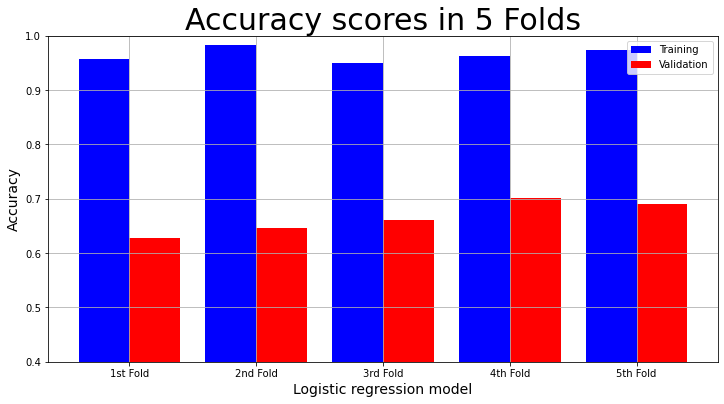

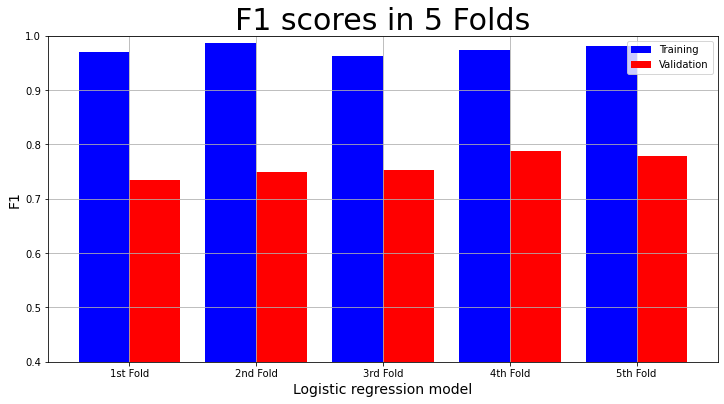

In [26]:
#plots
accuracy=supervised_learning_parameters_results("Logistic regression model",
            "Accuracy",
            "Accuracy scores in 5 Folds",
            cross_validation_results["Training Accuracy scores"],
            cross_validation_results["Validation Accuracy scores"])

F_score=supervised_learning_parameters_results("Logistic regression model",
            "F1",
            "F1 scores in 5 Folds",
            cross_validation_results["Training F1 scores"],
            cross_validation_results["Validation F1 scores"])

To remind : 

- accuracy : measures how many observations, here both HP and SSA, were correctly classified. $accuracy = \frac{well \ classified}{not \ well \ classified + well \ classified}$
- $F_1$ score : combines precision $F_1 = \frac{well \ classified \ 1}{well \ classified \ 1 + 0 \ classified \ as \ 1}$ and recall $\frac{well \ classified 1}{well \ classified \ 1 + 1 \ classified \ as \ 0}$ by its harmonic mean 

Here, we observe that accuracy and $F_1$ score are much better (closer to 1) for the trainsets than the validation sets, which seems to be due to **overfitting** : the model is too close to the trainset data to generalise. To avoid that, we could increase our dataset model, but also verify even more the annotation, as said previously, the images have been classified by 7 pathologists and the annotation was the one were most agreed, but as we can see it into the next plot (using the **bar_chart_pathologist_agreement** function), many samples do not make consensus for the annotation. Due to these low values, I did not try to evaluate my model on a testset.

In [20]:
#Function to plot the repartition of the number of samples where n pathologists agreed on the label

def bar_chart_pathologist_agreement(df_path,control_annotation,labels,xlab,ylab,title):
    df=pd.read_csv(df_path)
    df["Number of agreements"]=df[control_annotation]
    df.loc[df["Number of agreements"]==0,"Number of agreements"]=7
    df.loc[df["Number of agreements"]==1,"Number of agreements"]=6
    df.loc[df["Number of agreements"]==2,"Number of agreements"]=5
    df.loc[df["Number of agreements"]==3,"Number of agreements"]=4
    
    agreement_repartition=df["Number of agreements"].value_counts().sort_values().array

    fig, ax = plt.subplots()
    pps = ax.bar(labels,agreement_repartition,color ='maroon')
    for p in pps:
        height = p.get_height()
        ax.text(x=p.get_x() + p.get_width() / 2, y=height+.10,
                                          s="{}".format(height),
                                                        ha='center')
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(title)
    plt.show()

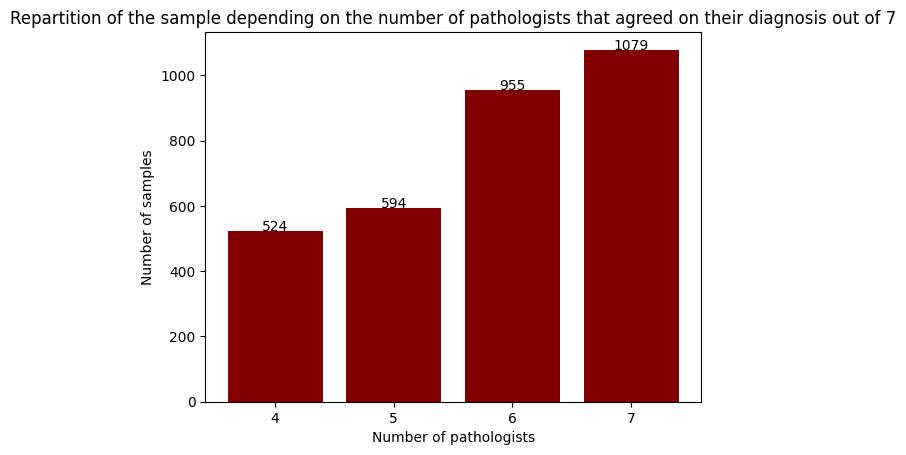

In [22]:
#plot the repartition of the number of samples where 7 pathologists agreed on the label of our samples
bar_chart_pathologist_agreement(df_path,
                                control_annotation="Number of Annotators who Selected SSA (Out of 7)",
                                labels=["4","5","6","7"],
                                xlab="Number of pathologists",
                                ylab="Number of samples",
                                title="Repartition of the sample depending on the number of pathologists that agreed on their diagnosis out of 7")

## Part III : Mitotic index 

Mitotic index is defined as the ratio between the number of a population's cells undergoing mitosis to its total number of cells. It is a measure of cellular proliferation, which is a prognosis of a cancerous lesion (and a precancerous lesion). It is calculated as the ratio $\frac{cells \ in \ mitosis}{total \ number \ of \ cells}$. The idea of this last part is to try to calculate mitotic index automatically. For that, we used images where we assumed that nucleus are darker than cytoplasm and that mitotic cells have very condensed chromosoms (even darker). After counting the number of nucleus and the number of condensed zones, we calculated the mitotic index as : $\frac{number \ of \ condensed \ zones}{number \ of \ nucleus + number \ of \ condensed \ zones}$. 


To analyze our data, we needed to use preprocessing : it is easyier to use black & white images (shades of gray), because it decreases one dimension (RGB to shades of gray). Then, we needed to filter the images to reduce the noise (we used a gaussian filter). Then, we thresholded the image to separate interphasic nucleus, mitotic chromosoms and the rest (cytoplasm, extracellular matrice, ...). 


Here, due to the low quality of the images used in part II, they were not usable (also, there were a lot of lymphocytes inside the extracellular matrice and their nucleus is very dark, and the images were not all focussing on epithelium only). Thus, we used images comming from the digital microscope developed by professor Michel Hérin at the University of Namur. We made two high resolution screenshots focusing on the epithelium, on an adenocarcinoma sample and a benign adenomatous polyp. 


In [27]:
#packages 
from skimage import (color, feature, filters, measure, morphology, segmentation, util)
from skimage import data
from skimage import io
from skimage.color import rgb2gray
from scipy.ndimage import gaussian_filter

In [28]:
#Image preprocessing
#Previous image processing function defined in a previous chunk in part I are used also in this part 
#Do not forget to run this previous chunk 

def open_in_gray(image_directory,image_name):
   """
   An image preprocessing to convert image in rgb to gray scale is needed in this part
   this function opens directly the image  in gray scale
   """
   image_dir=image_directory
   image_path=os.path.join(image_dir, image_name)
   image=io.imread(image_path)[:,:,:3]
   image=rgb2gray(image)

   return(image)


def gaussian_filtering(img,sigma): 
   """
   Gaussian Smoothing performs a weighted average of surrounding pixels based on the Gaussian distribution. 
   It is used to remove Gaussian noise
   input: 
   """
   sigma=sigma
   im_filtered=gaussian_filter(img,sigma)
   
   return im_filtered


def threshold_multiotsu(img, nb_classes):
    """
    multiotsu thresholding used to separate the pixels of an input image into several different classes,
    each one obtained according to the intensity of the gray levels within the image.
    input:
        img (image object, in gray)
        nb_classes (int): number of desired classes 
    output:
        thresholds (float): the limits between two classes 
        regions (int): region position delimited by their class (depending on the thresholds)
    """
    thresholds=filters.threshold_multiotsu(img,classes=nb_classes)
    regions=np.digitize(img,bins=thresholds)

    return thresholds,regions



def threshold_manual(img,nb_classes,threshold_1=0.15,threshold_2=0.30):
    """
    multiotsu thresholding used to separate the pixels of an input image into several different classes,
    each one obtained according to the intensity of the gray levels within the image.
    input:
        img (image object, in gray)
        nb_classes (int): number of desired classes 
    output:
        thresholds (float): the limits between two classes 
        regions (int): region position delimited by their class (depending on the thresholds)
    """
    thresholds = threshold_multiotsu(img,nb_classes)[0]
    thresholds[0]=threshold_1
    thresholds[1]=threshold_2
    regions=np.digitize(img,bins=thresholds)

    return thresholds, regions

In [29]:
#function to count the mitotic index
#count the number of cells aigain # make a function !!!

def mitotic_index(thresholded_image,thresholds):
    """ 
    mitotic index =  number of a population's cells undergoing mitosis / its total number of cells
    An elevated mitotic index indicates more cells are dividing and is an important prognostic factor 
    predicting both overall survival and response to chemotherapy in most cancer types. 
    input:
        thresholded_image (img)
        thresholds (floats): 
            the darkest corresponds to mitotic chromosoms (under the first threshold),
            the cells are counted as the number of nuclei, meaning the zone approximated as the second darkest color
            and the darkest color (mitotic cells do not have a nucleic envelope anymore and have to be counted as 
            cells). Thus, correspond to zones < the second threshold 
    """
    cells=thresholded_image < thresholds[1]
    labeled_cells=measure.label(cells)
    number_of_cells=labeled_cells.max()
    
    dividing=thresholded_image < thresholds[0]
    labeled_dividing=measure.label(dividing)
    number_of_divisions=labeled_dividing.max()

    mitotic_index=number_of_divisions/number_of_cells
    return {"mitotic index =":mitotic_index,
            "number of cells =":number_of_cells, 
            "number of divisions =":number_of_divisions}

In [33]:
image_directory= os.path.join(general_path, 'data_part_3')
image_name_pathology='image_mitosis_count.png'
image_name_polip='image_polip.png'

### Output for the adenocarcinoma

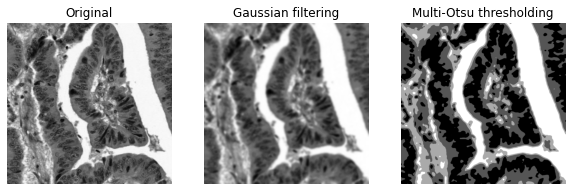

In [35]:
#output of pathologic image
image=open_in_gray(image_directory,image_name_pathology)
image_gaussian_filetered=gaussian_filtering(image,sigma=4)
image_multiotsu_thresholded=threshold_multiotsu(image_gaussian_filetered,nb_classes=4)

fig,ax=plt.subplots(ncols=3, figsize=(10, 5))
ax[0].imshow(image, cmap="gray")
ax[0].set_title('Original')
ax[0].axis('off')
ax[1].imshow(image_gaussian_filetered, cmap="gray")
ax[1].set_title('Gaussian filtering')
ax[1].axis('off')
ax[2].imshow(image_multiotsu_thresholded[1], cmap="gray")
ax[2].set_title('Multi-Otsu thresholding')
ax[2].axis('off')
plt.show()


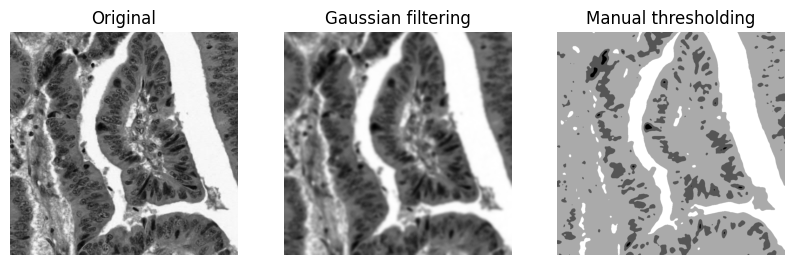

In [24]:
#manually changed thresholds 
image_manually_thresholded=threshold_manual(image_gaussian_filetered,nb_classes=4)


fig,ax=plt.subplots(ncols=3, figsize=(10, 5))
ax[0].imshow(image, cmap="gray")
ax[0].set_title('Original')
ax[0].axis('off')
ax[1].imshow(image_gaussian_filetered,cmap="gray")
ax[1].set_title('Gaussian filtering')
ax[1].axis('off')
ax[2].imshow(image_manually_thresholded[1],cmap="gray")
ax[2].set_title('Manual thresholding')
ax[2].axis('off')
plt.show()

In [21]:
###mitotic index 
mitotic_index(image_gaussian_filetered,image_manually_thresholded[0])

{'mitotic index =': 0.1032258064516129,
 'number of cells =': 155,
 'number of divisions =': 16}

With our image analysis count, we find out a mitotic index = 0.10.

### Output of adenomatous polyp

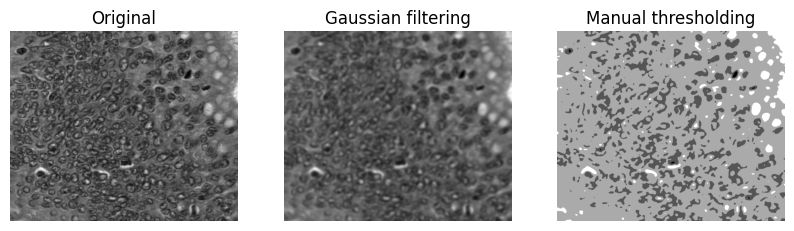

In [27]:
image_2=open_in_gray(image_directory,image_name_polip)
image_gaussian_filetered_2=gaussian_filtering(image_2,sigma=4)
image_manually_thresholded_2=threshold_manual(image_gaussian_filetered_2,nb_classes=4)
fig, ax=plt.subplots(ncols=3,figsize=(10, 5))
ax[0].imshow(image_2,cmap="gray")
ax[0].set_title('Original')
ax[0].axis('off')
ax[1].imshow(image_gaussian_filetered_2,cmap="gray")
ax[1].set_title('Gaussian filtering')
ax[1].axis('off')
ax[2].imshow(image_manually_thresholded_2[1],cmap="gray")
ax[2].set_title('Manual thresholding')
ax[2].axis('off')
plt.show()

In [28]:
mitotic_index(image_gaussian_filetered_2,image_manually_thresholded_2[0])

{'mitotic index =': 0.019736842105263157,
 'number of cells =': 304,
 'number of divisions =': 6}

For the adenomatous polyp, the mitotic index we found is 10 times smaller than the one we found into the adenocarcinoma image. 
It seems to be relevant. 


This model is far from perfect, if we had more time, we would have tried to use an R-CNN model to find the number of mitotic cells instead of this thresholding method. we tried to separate cells but it is very complicated due to the noise and the fact that we do not see clarly the membraneds. We tried to separate the nucleii as well but it is very compliated because their center are not the most constrasted part. 

# Conclusion

To conclude, colon adenocarcinoma is a cancer impacting developed countries, that can afford prevention and screening. The use of image analysis would be relevant for diagnosis and prognosis purposes, and could relieve physicians and even surpass them in these aspects. 